#### Import standard required modules

In [1]:
import control.matlab as c
import matplotlib.pyplot as plt
import numpy as np
import copy

In [2]:
#This keeps the notebook clean
import warnings
warnings.filterwarnings('ignore')

#### Import module 'functions'.
This contains functions based on provided matlab code, such as 'create_SS', which is based on cit2s.m and creates a state space system that includes gust effects. This module can be found in the same folder as this notebook.

In [3]:
import functions

### 1. Stability Analysis
#### 1.a Creating the state space systems
Creating the undamped state space system first, gust included:

In [4]:
undamped_sys = functions.create_SS()

The damped system is a copy of the undamped system that includes an active feedback loop with the control law $\delta_e = K_{\theta}$. The value of $K_\theta$ should be chosen such that the damping ratio of the phugoid is equal to $0.5$  and can be determined with the root locus plot of the undamped system.

In [5]:
%%capture
%matplotlib

#The two lines above force the plot to appear as a clickable interactive
#plot rather than an unclickable in-line plot

c.rlocus(undamped_sys[2,0], kvect=np.linspace(0, -50.0, num=1000),xlim=[-1.4,0],ylim=[-2.5,2.5])

Clicked at    -0.1073   +0.2083j gain    -0.1034 damp     0.4577


Clicking near the location of -0.12 + 0.20j on the interactive plot gives a damping ratio $\zeta$ of around 0.5 with a gain of -0.11. Finetuning this with trial and error in Python eventually results in a more exact gain of -0.117017. The damped system can now be found:

In [6]:
#First create a copy of the undamped system:
damped_sys = copy.deepcopy(undamped_sys)

#Create a feedback vector with K_theta at the theta position.
K_theta = -0.117017
K = [0, 0, K_theta, 0, 0, 0, 0]

#Add the feedback loop:
damped_sys.A = undamped_sys.A - undamped_sys.B[:,0]*K


Now there are state space systems for the damped and undamped case. Comparing the damping ratios of the phugoid eigenmotions shows that the damped system is properly damped:

In [11]:
#Round damping ratio to 5 nearest digits and select the damping ratios
#that belong to the phugoid eigenmotions.
zeta_undamped = round(c.damp(undamped_sys,doprint=False)[1][2],5)
zeta_damped = round(c.damp(damped_sys,doprint=False)[1][2],5)

print "Undamped damping ratio: "+str(zeta_undamped)
print "Damped damping ratio: "+str(zeta_damped)

Undamped damping ratio: 0.05038
Damped damping ratio: 0.5


#### 1.b) Analysis of results
A quick comparison of the step responses of both systems can give an indication of the stability of the systems.

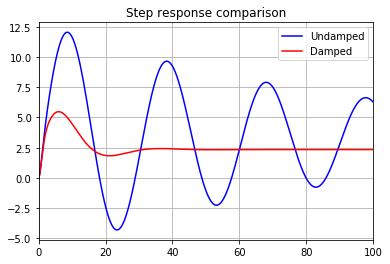

In [12]:
%matplotlib inline

#Create a large enough time scale
t = np.arange(0,100,0.01)

#Retrieve step response to default inputs
[y1, t] = c.step(undamped_sys[2,0], t)
[y2, t] = c.step(damped_sys[2,0], t)
                 
#Plot the figure
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(t, -y1, label="Undamped", color='b')
ax.plot(t, -y2, label="Damped", color='r')
ax.set_xlim([0,100])
plt.legend(loc='upper right')
plt.title("Step response comparison")
plt.grid()
plt.show()

Both systems appear stable and the system with the feedback loop is much better damped. Pole-zero maps confirm that both systems are stable:

Undamped short period eigenvalues:
(-1.3575968392623086+0.9612236445623191j)
(-1.3575968392623086-0.9612236445623191j)

Undamped phugoid eigenvalues:
(-0.010669092453275061+0.21152074168026475j)
(-0.010669092453275061-0.21152074168026475j)


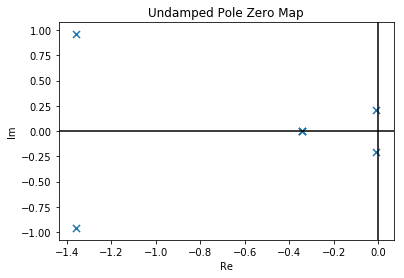

In [13]:
p, z = c.pzmap(undamped_sys[2,0], title="Undamped Pole Zero Map")

print "Undamped short period eigenvalues:"
print c.damp(undamped_sys,doprint=False)[2][0]
print c.damp(undamped_sys,doprint=False)[2][1]
print
print "Undamped phugoid eigenvalues:"
print c.damp(undamped_sys,doprint=False)[2][2]
print c.damp(undamped_sys,doprint=False)[2][3]

Damped short period eigenvalues:
(-1.2488363137555376+1.1989384131786862j)
(-1.2488363137555376-1.1989384131786862j)

Damped phugoid eigenvalues:
(-0.11942961796004511+0.20686026490812195j)
(-0.11942961796004511-0.20686026490812195j)


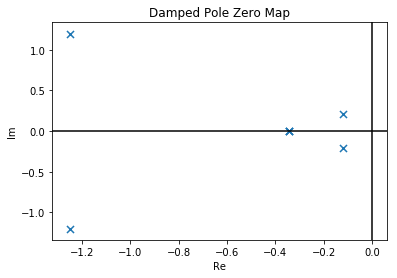

In [15]:
p, z = c.pzmap(damped_sys[2,0], title="Damped Pole Zero Map")

print "Damped short period eigenvalues:"
print c.damp(damped_sys,doprint=False)[2][0]
print c.damp(damped_sys,doprint=False)[2][1]
print
print "Damped phugoid eigenvalues:"
print c.damp(damped_sys,doprint=False)[2][2]
print c.damp(damped_sys,doprint=False)[2][3]

All the eigenvalues of both the damped and undamped short periods and phugoids have positive real parts, so both systems are longitudinally stable.